# Final Project: CHECKPOINT 1. 
Github link: https://github.com/kashyapkolukula/CMSC320_S25_Project

Datasets: 
* NBA Salaries: Hoops Fortune (2020-2025) https://www.kaggle.com/datasets/omarsobhy14/nba-players-salaries?resource=download
* NBA Stats (1947-present) https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats




# Final Project: CHECKPOINT 2. 
TODO: Submit a Jupyter notebook file (.ipynb) to Gradescope

Directions:
* (5 points) Data preprocessing: (a) import, (b) parse (e.g., convert strings to ints), (c) organize   (e.g., set up a database or a pandas DataFrame).
* (20 points) Basic data exploration and summary statistics
* You must present three conclusions using at least three different statistical methods, including hypothesis testing.
* For example: What are the main characteristics of your dataset? How many features and entries are there? Is a feature over-represented? Are features correlated? Are there outliers? Identify the attributes that will affect your choice of primary analysis technique. Etcetera.
* For each method, you must have at least one gorgeous plot.




In [ ]:
'''Kaggle datasts have been downloaded and can be found in "Data" folder.'''
# imports and libraries (not all may be needed)
import pandas as pd
import sqlite3
conn = sqlite3.connect("database.sqlite")
crsr = conn.cursor()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
import seaborn as sns
#from statsmodels.graphics.mosaicplot import mosaic # commented out because on my side it breaks the code
import numpy as np

In [196]:
''' DATA PROCESSING: LOAD IN DATAFRAMES, DROP COLUMNS '''
# Cleaned data of unessasary colummns for better computations


### In NBA_Salaries folder, main df
salaries_df = pd.read_csv("Data/NBA_Salaries_Hoops_Fortune_2020-2025/Nba Player Salaries.csv")

### In NBA_Stats folder
df_advanced = pd.read_csv("Data/NBA_Stats_1947-present/Advanced.csv") # Main df
df_advanced = df_advanced.drop(columns=['birth_year']) # mostly NA (91%)

### All player identified dataframes (even if teams exist too)
# could have made this a function..
df_all_star_selections = pd.read_csv("Data/NBA_Stats_1947-present/All-Star Selections.csv")
df_all_star_selections = df_all_star_selections.drop(columns=['lg']) # NBA (90%)

df_end_season_teams_voting = pd.read_csv("Data/NBA_Stats_1947-present/End of Season Teams (Voting).csv")
df_end_season_teams_voting = df_end_season_teams_voting.drop(columns=['lg']) # NBA (100%)

df_end_season_teams = pd.read_csv("Data/NBA_Stats_1947-present/End of Season Teams.csv")
df_end_season_teams = df_end_season_teams.drop(columns=['birth_year']) # mostly NA (86%)
df_end_season_teams = df_end_season_teams.drop(columns=['lg']) # mostly NBA (91%)
df_end_season_teams = df_end_season_teams.drop(columns=['player_id']) # have player names
df_end_season_teams = df_end_season_teams.drop(columns=['seas_id']) # have season already

df_per_100_poss = pd.read_csv("Data/NBA_Stats_1947-present/Per 100 Poss.csv")
df_per_100_poss = df_per_100_poss.drop(columns=['birth_year']) # mostly NA (95%)
df_per_100_poss = df_per_100_poss.drop(columns=['lg']) # mostly NBA (98%)
df_per_100_poss = df_per_100_poss.drop(columns=['player_id']) # have player names
df_per_100_poss = df_per_100_poss.drop(columns=['seas_id']) # have season already

df_per_36 = pd.read_csv("Data/NBA_Stats_1947-present/Per 36 Minutes.csv")
df_per_36 = df_per_36.drop(columns=['birth_year']) # mostly NA (91%)
df_per_36 = df_per_36.drop(columns=['lg']) # mostly NBA (93%)
df_per_36 = df_per_36.drop(columns=['player_id']) # have player names
df_per_36 = df_per_36.drop(columns=['seas_id']) # have season already

df_player_award_shares = pd.read_csv("Data/NBA_Stats_1947-present/Player Award Shares.csv")


df_player_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Player Per Game.csv")
df_player_per_game = df_player_per_game.drop(columns=['birth_year']) # mostly NA (91%)
df_player_per_game = df_player_per_game.drop(columns=['lg']) # mostly NBA (93%)
df_player_per_game = df_player_per_game.drop(columns=['player_id']) # have player names
df_player_per_game = df_player_per_game.drop(columns=['seas_id']) # have season already

df_player_play_by_play = pd.read_csv("Data/NBA_Stats_1947-present/Player Play By Play.csv")
df_player_play_by_play = df_player_play_by_play.drop(columns=['birth_year']) # mostly NA (99%)
df_player_play_by_play = df_player_play_by_play.drop(columns=['lg']) # NBA (100%)
df_player_play_by_play = df_player_play_by_play.drop(columns=['player_id']) # have player names
df_player_play_by_play = df_player_play_by_play.drop(columns=['seas_id']) # have season already

df_player_season_info = pd.read_csv("Data/NBA_Stats_1947-present/Player Season Info.csv")
df_player_season_info = df_player_season_info.drop(columns=['birth_year']) # mostly NA (91%)
df_player_season_info = df_player_season_info.drop(columns=['lg']) # mostly NBA (93%)
df_player_season_info = df_player_season_info.drop(columns=['player_id']) # have player names
df_player_season_info = df_player_season_info.drop(columns=['seas_id']) # have season already

df_player_shooting = pd.read_csv("Data/NBA_Stats_1947-present/Player Shooting.csv")
df_player_shooting = df_player_shooting.drop(columns=['birth_year']) # mostly NA (99%)
df_player_shooting = df_player_shooting.drop(columns=['lg']) # NBA (100%)
df_player_shooting = df_player_shooting.drop(columns=['player_id']) # have player names
df_player_shooting = df_player_shooting.drop(columns=['seas_id']) # have season already

df_player_totals = pd.read_csv("Data/NBA_Stats_1947-present/Player Totals.csv")
df_player_totals = df_player_totals.drop(columns=['birth_year']) # mostly NA (91%)
df_player_totals = df_player_totals.drop(columns=['lg']) # mostly NBA (93%)
df_player_totals = df_player_totals.drop(columns=['player_id']) # have player names
df_player_totals = df_player_totals.drop(columns=['seas_id']) # have season 


df_player_career_info = pd.read_csv("Data/NBA_Stats_1947-present/Player Career Info.csv")
df_player_career_info = df_player_career_info.drop(columns=['birth_year']) # mostly NA (93%)

df_player_directory = pd.read_csv("Data/NBA_Stats_1947-present/Player Directory.csv")

### All team identified dataframes

df_opponent_stats_per_100 = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Stats Per 100 Poss.csv")
df_opponent_stats_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Stats Per Game.csv")
df_opponent_totals = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Totals.csv")

df_team_abbrev = pd.read_csv("Data/NBA_Stats_1947-present/Team Abbrev.csv")
df_team_stats_per_100 = pd.read_csv("Data/NBA_Stats_1947-present/Team Stats Per 100 Poss.csv")
df_team_stats_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Team Stats Per Game.csv")
df_team_summaries = pd.read_csv("Data/NBA_Stats_1947-present/Team Summaries.csv")
df_team_totals = pd.read_csv("Data/NBA_Stats_1947-present/Team Totals.csv")

salaries_method2 = salaries_df.copy()
df_advanced_method2 = df_advanced.copy()


In [197]:
salary_long = (
    salaries_df
    .melt(id_vars="Player Name", 
          value_vars=["2022/2023", "2023/2024", "2024/2025"],
          var_name="Season", 
          value_name="Salary")
    .replace({"Salary": r"[\$,]"}, {"Salary": ""}, regex=True)
    .assign(
        Salary=lambda d: pd.to_numeric(d["Salary"], errors="coerce"),
        player=lambda d: d["Player Name"].str.strip(),
        season=lambda d: d["Season"].str.extract(r"(\d{4})").astype(int)
    )
    .drop(columns=["Player Name"])
    .dropna(subset=["Salary"])
)

In [198]:
df_advanced["player"] = df_advanced["player"].str.strip()
df_advanced = df_advanced[df_advanced["lg"] == "NBA"]
df_advanced = df_advanced[df_advanced["season"].between(2020, 2025)]

In [199]:
gold_df = pd.merge(
    df_advanced,
    salary_long,
    on=["player", "season"],
    how="inner"
).reset_index(drop=True)

print(gold_df.shape)

(1618, 33)


Notes from cleaning up the data:
* There are 5266 players total, when restricting to 2022-2026 there are 499 total players
* There are repeated player names in the advanded_df
* Advanced has the most general data
* Many columns are repeated (kaggle has better visuals)
* Many of the loaded df's can be used to create columns of players with certain characteristics
* Dropped some columns like birth year since there is more useful columns in the "advanced_df"

###############################################################################################################################

Method 1: Correlation Matrix with Heatmap Visualization

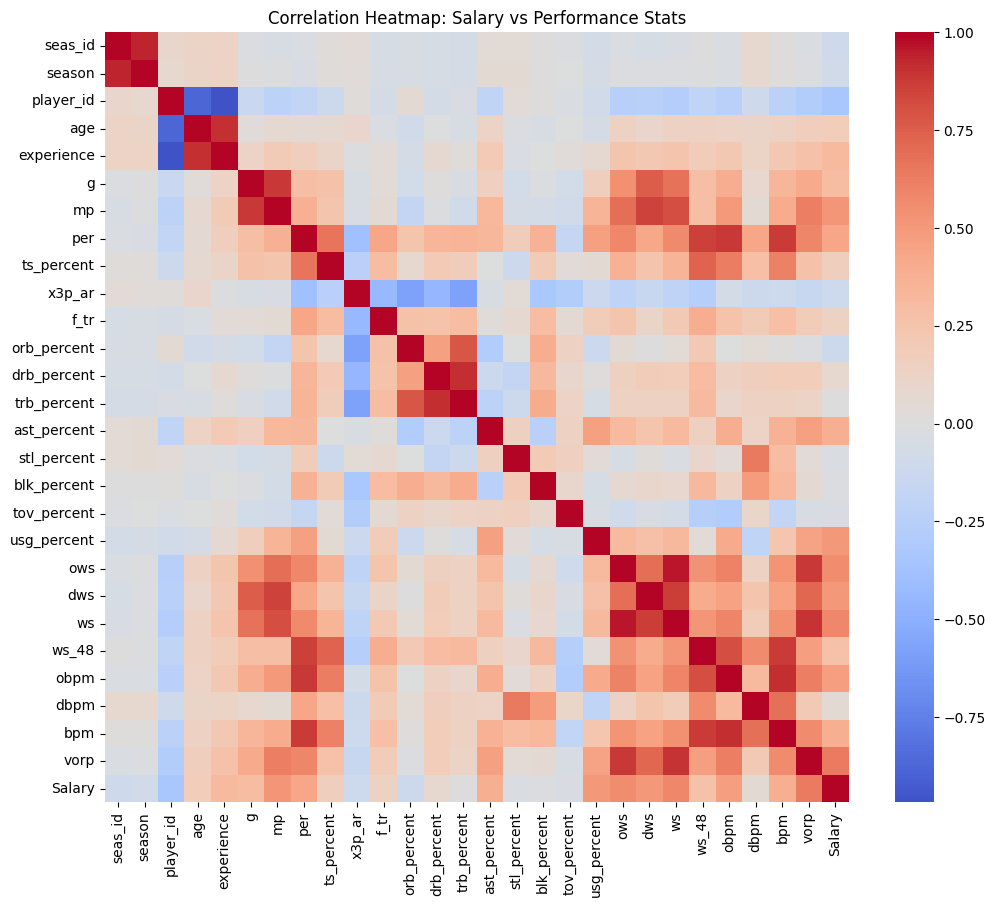

Salary         1.000000
vorp           0.637568
ws             0.581336
ows            0.554892
mp             0.518558
dws            0.507142
usg_percent    0.501092
obpm           0.475854
per            0.432603
bpm            0.389472
Name: Salary, dtype: float64


In [200]:

correlation_matrix = gold_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Salary vs Performance Stats")
plt.show()

print(correlation_matrix["Salary"].sort_values(ascending=False).head(10))

###############################################################################################################################

In [201]:
''' DATA PROCESSING: parsing, organizing and cnverting for method 2 and method 3 '''

# Parse salaries_method2 to merge with other df's, rename player column and format yearly salary to match seasons columns
salaries_method2.rename(columns={'Player Name': 'player'}, inplace=True)
# Identify season columns (years)
season_cols = [col for col in salaries_method2.columns if '/' in col]
salaries_curr_format = salaries_method2.melt( id_vars='player', value_vars=season_cols, var_name='year_label', value_name='salary')
# Fix the incorrect duplicate season column name
salaries_method2.rename(columns={'2024/2025.1': '2025/2026'}, inplace=True)
# Convert: '2022/2023' -> 2023 and name column season to match
salaries_curr_format['season'] = salaries_curr_format['year_label'].str.extract(r'/(\d{4})')
salaries_curr_format = salaries_curr_format.dropna(subset=['season'])
salaries_curr_format['season'] = salaries_curr_format['season'].astype(int)

# Filters out names in both dataframes that do not match
salaries_method2 = salaries_method2[salaries_method2['player'].isin(df_advanced_method2['player'])].copy()
df_advanced_method2 = df_advanced_method2[df_advanced_method2['player'].isin(salaries_method2['player'])].copy() # since salaries are recoreded from 2020-2025, should narrow it down w/o filter


In [202]:

# filter names for names matching, and seasons not between 2020-2025 (2022-2026 season) on the other dataframes 
def filter_player_df(df, player_col='player', season_col='season'):
    df = df[df[player_col].isin(salary_long['player'])].copy()
    if season_col in df.columns:
        df = df[df[season_col].between(2020, 2025)]
    return df

# Use definition to filter all the dataframes with a seasons column and a player name column

# filters all df with player column. Used in linear regression models.
df_player_per_game = filter_player_df(df_player_per_game)
df_player_play_by_play = filter_player_df(df_player_play_by_play)
df_player_shooting = filter_player_df(df_player_shooting)
df_player_totals = filter_player_df(df_player_totals)


df_player_season_info = filter_player_df(df_player_season_info) # good to be used as a control group
df_per_36 = filter_player_df(df_per_36)  # redundant with advanced, could showcase undervalued players
df_per_100_poss = filter_player_df(df_per_100_poss) # may be less useful
df_end_season_teams = filter_player_df(df_end_season_teams) # may be less useful, redundant with team awards
df_end_season_teams_voting = filter_player_df(df_end_season_teams_voting) # may be less useful than award shares
df_all_star_selections = filter_player_df(df_all_star_selections) # could be used to answer secondary correlation questions (was person paid more an all star)
df_player_award_shares = filter_player_df(df_player_award_shares) # may be less useful

# Drop season_id and player_id on two df's still with them
df_end_season_teams_voting = df_end_season_teams_voting.drop(columns=['player_id']) # have player names
df_end_season_teams_voting = df_end_season_teams_voting.drop(columns=['seas_id']) # have season already
df_player_award_shares = df_player_award_shares.drop(columns=['player_id']) # have player names
df_player_award_shares = df_player_award_shares.drop(columns=['seas_id']) # have season already



Method 2: One way ANOVA test

Question: Is mean salary significantly different depending on position?

Null Hypothesis: Mean salary is not statistically significant different depending on position.

Alternative Hypothesis: Mean salary is statistically significant different depending on position.

ANOVA Results:
F-statistic: 8.182
p-value: 0.000


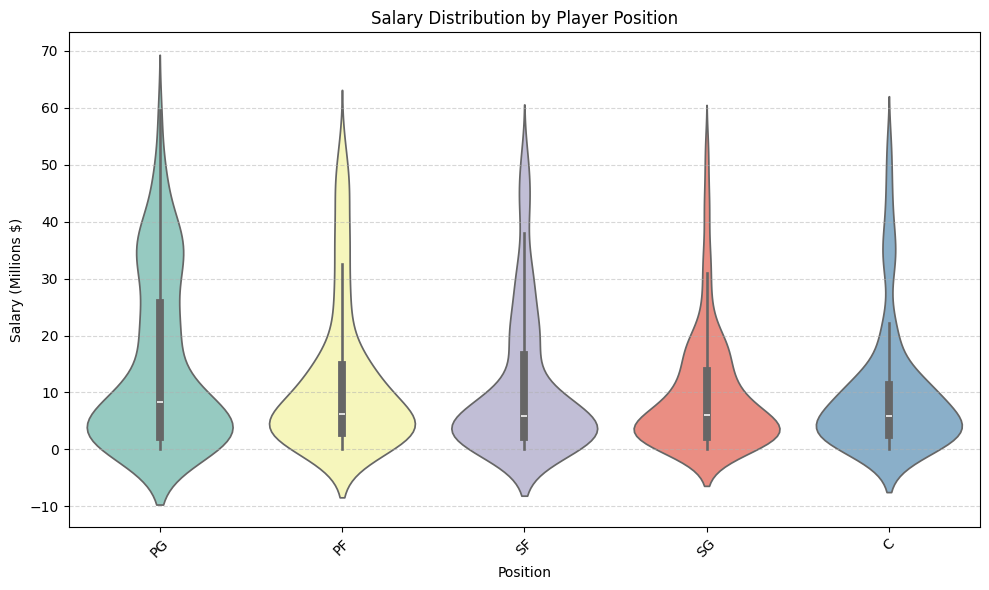

In [203]:

salaries_curr_format['salary'] = (
    salaries_curr_format['salary']
    .replace(r'[\$,]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

salary_with_pos = pd.merge(
    salaries_curr_format,
    df_player_season_info[['player', 'season', 'pos']],
    on=['player', 'season'],
    how='inner'
)

pure_positions = ['PG', 'SG', 'SF', 'PF', 'C']
salary_with_pos = salary_with_pos[
    (salary_with_pos['salary'] > 0) & 
    (salary_with_pos['pos'].isin(pure_positions))
].copy()

salary_with_pos['salary_millions'] = salary_with_pos['salary'] / 1e6

grouped_salaries = salary_with_pos.groupby('pos')['salary'].apply(list)
anova_result = f_oneway(*grouped_salaries)

print("ANOVA Results:")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue:.3f}")

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=salary_with_pos,
    x="pos",
    y="salary_millions",
    hue="pos",
    legend=False,
    inner="box",
    palette="Set3"
)
plt.title("Salary Distribution by Player Position")
plt.xlabel("Position")
plt.ylabel("Salary (Millions $)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

According to the One way ANOVA test done on the data, and the p-value which is less than 0.05. We can reject the null hypothesis. The violin plot also shows us the density of salaries around the boxplot of depsciptive statistics.

###############################################################################################################################

Method 3: Linear Regression Model with Scatter plots AND Bar plots of coefficients

Coeffiecient Plots:
* Does Performance Predict Salary?  
* Does Shot Profile Drive Salary?   
* Do Impact Stats Predict Salary? 

Regression Models:
* Is Age Related to Salary?         
* Is Experience Related to Salary?  
* Is salary proportional to minutes played?

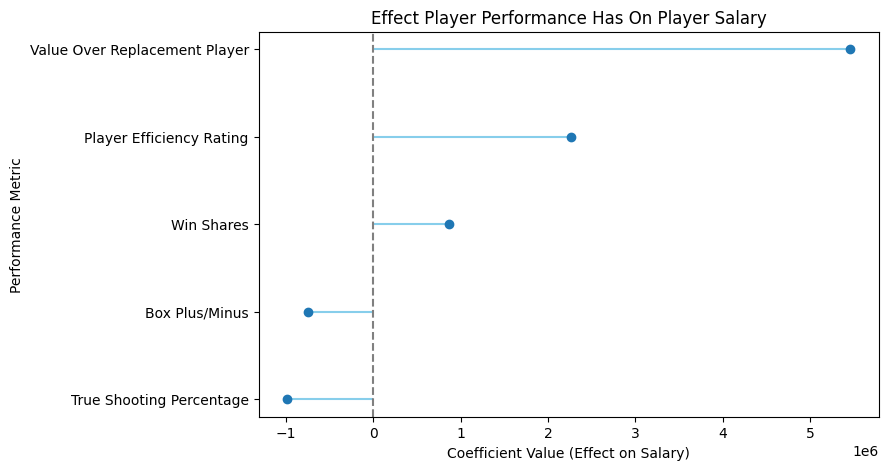

Win Shares: 1 SD change (2.4) → $2,103,947 (28.8% of avg salary)
Value Over Replacement Player: 1 SD change (1.1) → $6,077,465 (83.1% of avg salary)
Box Plus/Minus: 1 SD change (4.3) → $-3,239,977 (-44.3% of avg salary)
Player Efficiency Rating: 1 SD change (5.6) → $12,592,377 (172.1% of avg salary)
True Shooting Percentage: 1 SD change (0.1) → $-104,229 (-1.4% of avg salary)


In [204]:
# Does Performance Predict Salary?  
df_cleaned = gold_df[['ws', 'vorp', 'bpm', 'per', 'ts_percent', 'Salary']].dropna()

X = df_cleaned[['ws', 'vorp', 'bpm', 'per', 'ts_percent']].rename(columns={
    'ws': 'Win Shares',
    'vorp': 'Value Over Replacement Player',
    'bpm': 'Box Plus/Minus',
    'per': 'Player Efficiency Rating',
    'ts_percent': 'True Shooting Percentage'
})

y = df_cleaned['Salary']


model = LinearRegression()
model.fit(x, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
model.fit(X_scaled, y)
std_coefs = pd.Series(model.coef_, index=X.columns)

coefs_sorted = std_coefs.sort_values()

plt.figure(figsize=(8,5))
plt.hlines(y=coefs_sorted.index, xmin=0, xmax=coefs_sorted.values, color="skyblue")
plt.plot(coefs_sorted.values, coefs_sorted.index, "o")
plt.axvline(0, color="grey", linestyle="--")
plt.title("Effect Player Performance Has On Player Salary")
plt.xlabel("Coefficient Value (Effect on Salary)")
plt.ylabel("Performance Metric")
plt.show()

general_change = std_coefs.copy()

mean_salary = y.mean()
for metric in general_change.index:
    realistic_change = X[metric].std()  # Using 1 standard deviation change
    dollar_impact = general_change[metric] * realistic_change
    pct_impact = (dollar_impact / mean_salary) * 100
    print(f"{metric}: 1 SD change ({realistic_change:.1f}) → ${dollar_impact:,.0f} ({pct_impact:.1f}% of avg salary)")

change = general_change * X.std()
change = change.sort_values()


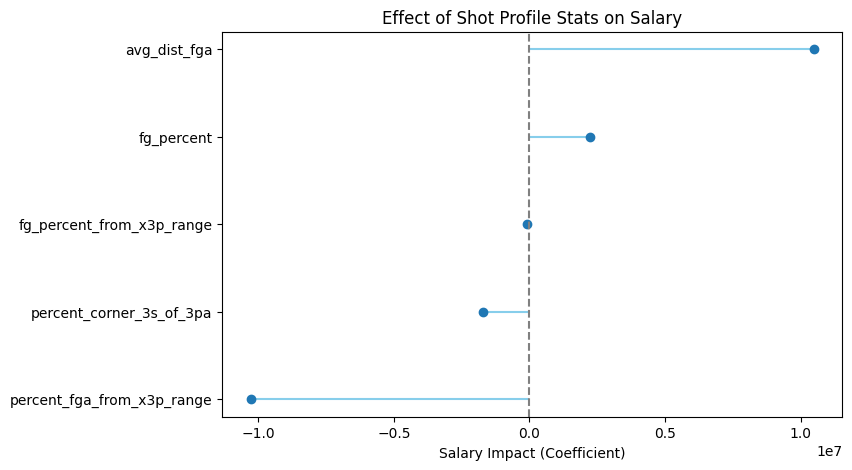

fg_percent: 1 SD change (0.1) → $221,270 (3.0% of avg salary)
avg_dist_fga: 1 SD change (4.9) → $51,070,944 (683.5% of avg salary)
percent_fga_from_x3p_range: 1 SD change (0.2) → $-2,188,764 (-29.3% of avg salary)
fg_percent_from_x3p_range: 1 SD change (0.1) → $-11,675 (-0.2% of avg salary)
percent_corner_3s_of_3pa: 1 SD change (0.2) → $-327,483 (-4.4% of avg salary)


In [205]:
# Does Shot Profile Drive Salary?   
# Merge salary into shooting DF
df = df_player_shooting.merge(salary_long, on=["player", "season"], how="inner")
df = df.dropna(subset=["Salary"])

# Pick relevant columns
shot_cols = [
    'fg_percent',
    'avg_dist_fga',
    'percent_fga_from_x3p_range',
    'fg_percent_from_x3p_range',
    'percent_corner_3s_of_3pa'
]

# Drop NaNs in these columns
shot_df = df[shot_cols + ['Salary']].dropna()

X = shot_df[shot_cols]
y = shot_df['Salary']

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)
std_coefs_shot = pd.Series(model.coef_, index=X.columns)

coefs_sorted = std_coefs_shot.sort_values()

# Plot
plt.figure(figsize=(8,5))
plt.hlines(y=coefs_sorted.index, xmin=0, xmax=coefs_sorted.values, color="skyblue")
plt.plot(coefs_sorted.values, coefs_sorted.index, "o")
plt.title("Effect of Shot Profile Stats on Salary")
plt.xlabel("Salary Impact (Coefficient)")
plt.axvline(0, color="grey", linestyle="--")
plt.show()


# show the change in salary 1 standard deviation from the mean.
shot_profile = std_coefs_shot.copy()

mean_salary = y.mean()
for metric in shot_profile.index:
    realistic_change = X[metric].std()  # Using 1 standard deviation change
    dollar_impact = shot_profile[metric] * realistic_change
    pct_impact = (dollar_impact / mean_salary) * 100
    print(f"{metric}: 1 SD change ({realistic_change:.1f}) → ${dollar_impact:,.0f} ({pct_impact:.1f}% of avg salary)")

change = shot_profile * X.std()
change = change.sort_values()


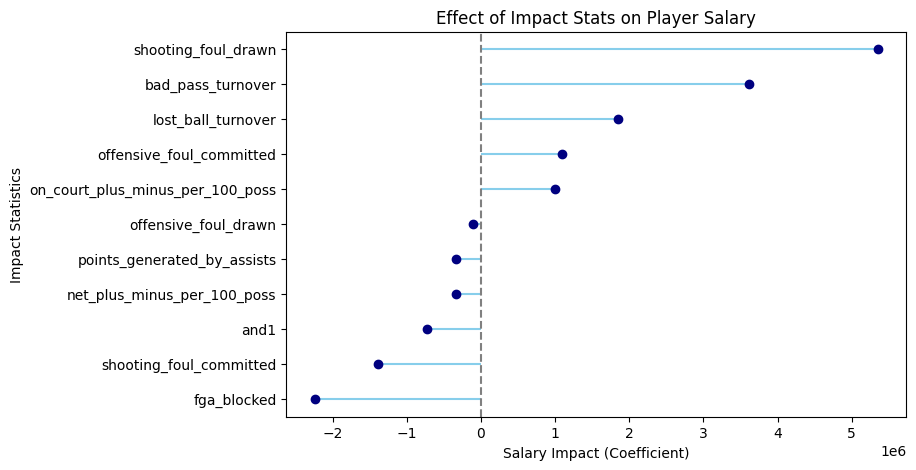

on_court_plus_minus_per_100_poss: 1 SD change (12.9) → $12,860,314 (176.4% of avg salary)
net_plus_minus_per_100_poss: 1 SD change (13.0) → $-4,436,536 (-60.9% of avg salary)
points_generated_by_assists: 1 SD change (301.1) → $-102,235,335 (-1402.4% of avg salary)
bad_pass_turnover: 1 SD change (30.5) → $110,278,962 (1512.7% of avg salary)
lost_ball_turnover: 1 SD change (16.3) → $30,179,044 (414.0% of avg salary)
shooting_foul_drawn: 1 SD change (52.7) → $282,514,698 (3875.3% of avg salary)
shooting_foul_committed: 1 SD change (31.9) → $-44,392,775 (-608.9% of avg salary)
offensive_foul_committed: 1 SD change (8.4) → $9,143,616 (125.4% of avg salary)
offensive_foul_drawn: 1 SD change (9.5) → $-1,046,394 (-14.4% of avg salary)
and1: 1 SD change (13.6) → $-9,840,682 (-135.0% of avg salary)
fga_blocked: 1 SD change (20.6) → $-46,185,062 (-633.5% of avg salary)


In [206]:
# Do “Impact Stats” Predict Salary? 
# Ensure no NaNs
impact_cols = [
    "on_court_plus_minus_per_100_poss",
    "net_plus_minus_per_100_poss",
    "points_generated_by_assists",
    "bad_pass_turnover",
    "lost_ball_turnover",
    "shooting_foul_drawn",
    "shooting_foul_committed",
    "offensive_foul_committed",
    "offensive_foul_drawn",
    "and1",
    "fga_blocked"
]

impact_df = df_player_play_by_play.merge(
    salary_long,
    on=["player", "season"],
    how="inner"
).dropna(subset=impact_cols + ["Salary"])

X = impact_df[impact_cols]
y = impact_df['Salary']

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)
std_coefs_imp = pd.Series(model.coef_, index=X.columns)

coefs_sorted = std_coefs_imp.sort_values()

# Plot
plt.figure(figsize=(8,5))
plt.hlines(y=coefs_sorted.index, xmin=0, xmax=coefs_sorted.values, color="skyblue")
plt.plot(coefs_sorted.values, coefs_sorted.index, "o", color="navy")
plt.axvline(0, color="grey", linestyle="--")
plt.title("Effect of Impact Stats on Player Salary")
plt.xlabel("Salary Impact (Coefficient)")
plt.ylabel("Impact Statistics")
plt.show()


# show the change in salary 1 standard deviation from the mean.
performance_impact = std_coefs_imp.copy()

mean_salary = y.mean()
for metric in performance_impact.index:
    realistic_change = X[metric].std()  # Using 1 standard deviation change
    dollar_impact = performance_impact[metric] * realistic_change
    pct_impact = (dollar_impact / mean_salary) * 100
    print(f"{metric}: 1 SD change ({realistic_change:.1f}) → ${dollar_impact:,.0f} ({pct_impact:.1f}% of avg salary)")

change = performance_impact * X.std()
change = change.sort_values()

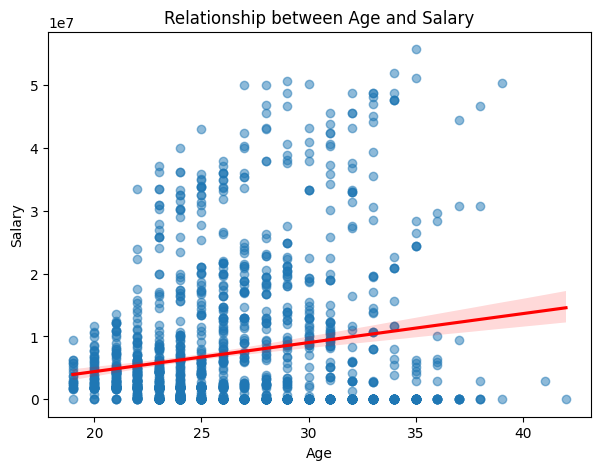

In [207]:
# Is Age Related to Salary?        
age_salary = gold_df.dropna(subset=["age", "Salary"])

plt.figure(figsize=(7,5))
sns.regplot(
    data=age_salary,
    x="age",
    y="Salary",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Relationship between Age and Salary")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.show()



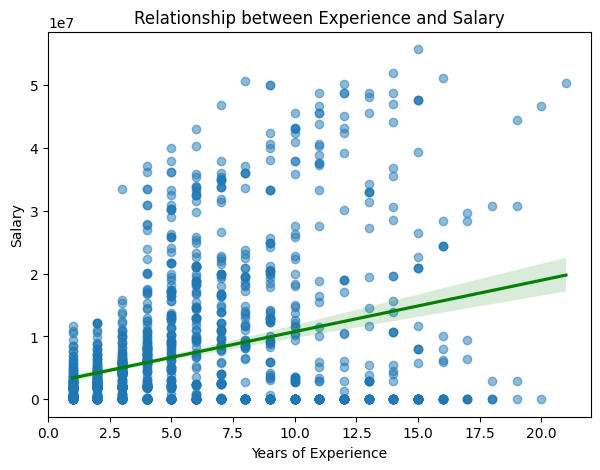

In [208]:
# Is Experience Related to Salary?  
exp_df = df_player_totals.merge(
    salary_long,
    on=["player", "season"],
    how="inner"
).dropna(subset=["experience", "Salary"])

plt.figure(figsize=(7,5))
sns.regplot(
    data=exp_df,
    x="experience",
    y="Salary",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"green"}
)
plt.title("Relationship between Experience and Salary")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()


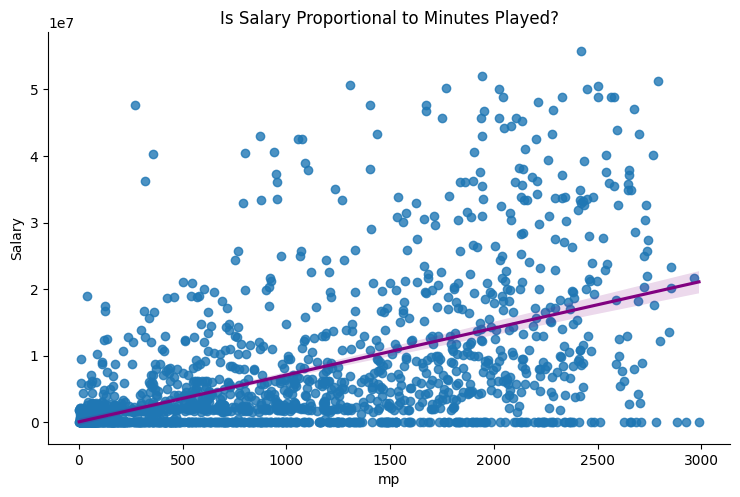

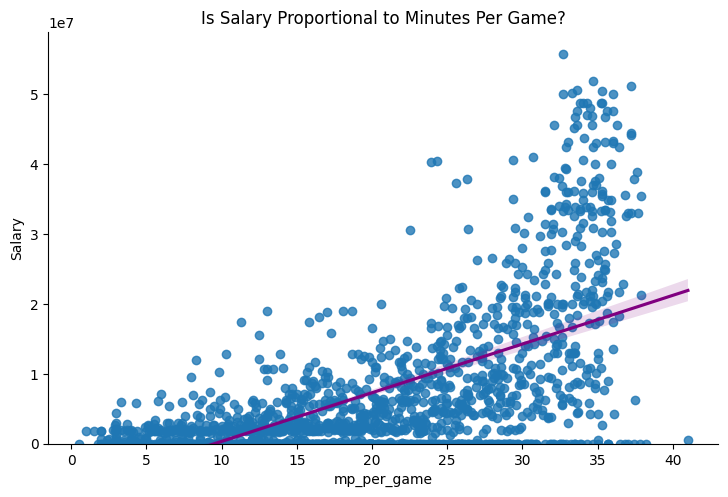

In [209]:
# Is salary proportional to minutes played?

sns.lmplot(data=gold_df, x='mp', y='Salary', height=5, aspect=1.5, line_kws={"color":"purple"})
plt.title("Is Salary Proportional to Minutes Played?")
plt.show()

# Merge per-game with salary
mp_df = df_player_per_game.merge(
    salary_long, on=['player', 'season'], how='inner'
)

sns.lmplot(data=mp_df, x='mp_per_game', y='Salary', height=5, aspect=1.5, line_kws={"color":"purple"})
plt.ylim(-0.05, None)   # Force y-axis lower bound to zero
plt.title("Is Salary Proportional to Minutes Per Game?")
plt.show()
